In [1]:
import os
import json 
import logging

logging.basicConfig(
    filename='log/app.log',            # Specify the log file name
    level=logging.DEBUG,           # Set the log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Set the log format
)

# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token

In [2]:
import torch 
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from PIL import Image
import requests
import matplotlib.pyplot as plt

import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from accelerate import Accelerator

import logging
import sys

accelerator = Accelerator()
device = accelerator.device
# device = 'cuda:3'

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from maskgen.utils.vit_mod import ModViTForImageClassification

In [4]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

original_model = ViTForImageClassification.from_pretrained(pretrained_name)
state_dict = original_model.state_dict()
del original_model # remove the model to free up memory
# change to use_mask_token = True
pred_model = ModViTForImageClassification(config)
# load back the parameters from state_dict
# 为新的模型实例添加 mask_token 权重
if 'vit.embeddings.mask_token' not in state_dict:
    state_dict['vit.embeddings.mask_token'] = pred_model.vit.embeddings.mask_token

pred_model.load_state_dict(state_dict)

pred_model.to(device)
# set to eval mode
pred_model.eval()
print()

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


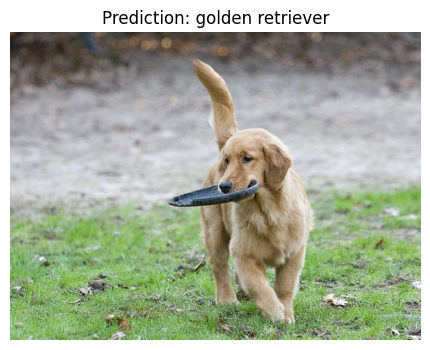

In [5]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = pred_model.config.id2label[predicted_class_idx]

plt.figure(figsize=(6, 4))  # 设置图像显示的大小
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

# 创建peft model 

In [6]:
from peft import LoraConfig, get_peft_model
# We use the same foundation model
exp_base_model = ViTModel.from_pretrained(pretrained_name)

# convert to peft model and ready to use LoRA 
# 手动列出所有层的目标模块

target_modules = []
num_layers = 12  # BERT-base 有 12 层
for i in range(num_layers):
    target_modules.extend([
        f"encoder.layer.{i}.attention.attention.query",
        f"encoder.layer.{i}.attention.attention.key",
        f"encoder.layer.{i}.attention.attention.value",
        f"encoder.layer.{i}.attention.output.dense",
        f"encoder.layer.{i}.intermediate.dense",
        f"encoder.layer.{i}.output.dense"
    ])

lora_config = LoraConfig(
    r=4,  # 低秩矩阵的秩
    lora_alpha=32,  # LoRA 的缩放因子
    target_modules= target_modules,  # 目标模块
    lora_dropout=0.1  # Dropout 概率
)
exp_base_model = get_peft_model(exp_base_model, lora_config)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from maskgen.vision_models.vision_maskgen_clip2 import MaskGeneratingModel

mask_gen_model = MaskGeneratingModel(base_model=exp_base_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
print()

In [8]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()
dataset = load_dataset("mrm8488/ImageNet1K-val")['train']

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)
dataset.set_transform(preprocess)


batch_size = 1024
# train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
# train_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

num_steps = 20
optimizer = torch.optim.Adam(mask_gen_model.parameters(), lr=1e-4, weight_decay=1e-5)


Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [9]:
from tqdm import tqdm

for epoch in range(1):
    pbar = tqdm(train_dataloader)
    for idx, data in enumerate(pbar):
        pixel_values = data['pixel_values'].to(device)

        loss_dict = mask_gen_model.train_one_batch(pred_model, pixel_values, optimizer, num_steps=5, mini_batch_size=256, ppo_epochs=2)
        if idx % 1 == 0:
            print(f"Epoch {epoch+1}, Step {idx+1}: Loss = {loss_dict['loss']:.4f}, " 
                                    f"Actor Loss = {loss_dict['actor_loss']:.4f}, "
                                    f"Critic Loss = {loss_dict['critic_loss']:.4f}, "
                                    f"Entropy = {loss_dict['entropy']:.4f}, "
                                    f"Returns = {loss_dict['returns']:.4f}"
                                    )



  2%|▏         | 1/49 [01:04<51:18, 64.13s/it]

Epoch 1, Step 1: Loss = 0.4836, Actor Loss = -1.1047, Critic Loss = 3.1767, Entropy = 0.6892, Returns = 1.5208


  4%|▍         | 2/49 [02:08<50:16, 64.18s/it]

Epoch 1, Step 2: Loss = 0.2804, Actor Loss = -0.8881, Critic Loss = 2.3372, Entropy = 0.6893, Returns = 1.3488


  4%|▍         | 2/49 [03:11<1:15:06, 95.89s/it]


KeyboardInterrupt: 

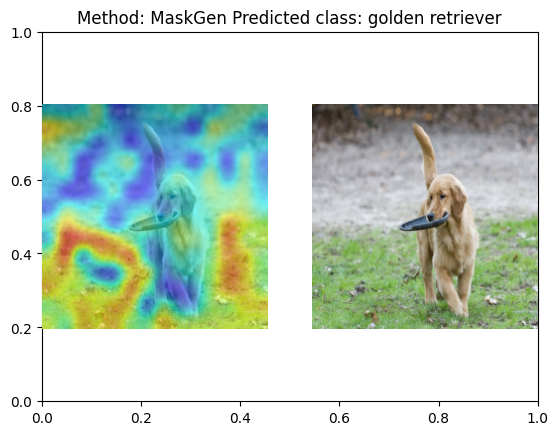

In [13]:
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils import idx_to_selector

mask_gen_model.eval()

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    pred_class = pred_model(img).logits.argmax(-1)
    predicted_class_idx = pred_class.item()

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
size = 14
N = inputs['pixel_values'].shape[0]

# sim = mask_gen_model.forward(pixel_values=inputs['pixel_values'])
dist, value = mask_gen_model.get_dist_critic(inputs['pixel_values'])
sim_logits = dist.logits
sim = torch.sigmoid(sim_logits)
# selector = idx_to_selector(pred_class, 1000).unsqueeze(1) # [N, 1, n_classes]
# sim = (sim * selector).sum(-1)
# sim = sim[:,:, predicted_class_idx]

heatmap = torch.sigmoid(sim).reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [ ]:
print(heatmap.min())
print(heatmap.max())
print(heatmap.mean())

0.62643015
0.67950237
0.6537656


In [ ]:
# save model to trained folder
import os
from datetime import datetime
state_dict = mask_gen_model.state_dict()
model_name = "vision_lora_clip_En0.1_" + datetime.now().strftime("%Y%m%d-%H%M%S") + ".pt"
model_path = os.path.join("trained", model_name)
torch.save(state_dict, model_path)


In [ ]:
# how to check the size of the model in MB
import os
print(f"Model size: {os.path.getsize(model_path) / 1e6:.2f} MB")

Model size: 353.17 MB
